### The correlation of observed precipitation data with dry spells
This notebook explores the correlation between observed precipitation and dry spells. 
We transform the observed precipitation to correspond with the format that precipitation **forecasts** are published in.   
We do this since the goal of the analysis is to see if, given perfect forecasting skill, there is information in the forecasted quantities for forecasting dryspells. 

We explore the following precipitation-related variables:
- Lower tercile (i.e. below-average) monthly precipitation
- Lower tercile 3-monthly (i.e. seasonal) precipitation
- [TODO: ENSO state]    


We prefer to use as many readily available products as we can. However, we could only find historical monthly terciles (using CAMS-OPI data) and not historical seasonal terciles. We have therefore computed these seasonal terciles ourselves. As source we use CHIRPS data as this is also the source used to compute the dry spells, we have experience working with this source, has a high resolugion, and generally speaking good performance. 

Since the code to compute monthly terciles is almost the same as seasonal, we also propose to use the CHIRPS methodology to compute the monthly terciles instead of using the readily available CAMS-OPI terciles. 

### set general variables and functions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
from rasterio.enums import Resampling
import matplotlib.colors as mcolors
import xarray as xr
import cftime
import math
import rioxarray
from shapely.geometry import mapping
import cartopy.crs as ccrs
import matplotlib as mpl
import seaborn as sns

In [3]:
from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
print(path_mod)
sys.path.append(path_mod)
from src.indicators.drought.config import Config
from src.utils_general.utils import download_ftp,download_url
from src.utils_general.raster_manipulation import fix_calendar, invert_latlon, change_longitude_range
from src.utils_general.plotting import plot_raster_boundaries_clip

/Users/tinkavalentijn/Documents/CHD/AAFI/pa-anticipatory-action/


#### Set config values

In [4]:
country="malawi"
config=Config()
parameters = config.parameters(country)
country_dir = os.path.join(config.DIR_PATH, config.ANALYSES_DIR, country)
country_data_raw_dir = os.path.join(config.DATA_DIR,config.RAW_DIR,country)
country_data_exploration_dir = os.path.join(config.DATA_DIR,"exploration",country)
drought_data_exploration_dir= os.path.join(config.DATA_DIR, "exploration",  'drought')
cams_data_dir=os.path.join(drought_data_exploration_dir,"CAMS_OPI")
cams_tercile_path=os.path.join(cams_data_dir,"CAMS_tercile.nc")
chirps_monthly_dir=os.path.join(drought_data_exploration_dir,"CHIRPS")
chirps_monthly_path=os.path.join(chirps_monthly_dir,"chirps_global_monthly.nc")

In [5]:
adm1_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
adm2_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

### CHIRPS seasonal
Optimally we would use data that is already processed to indicate the percentile per season and year. However, we couldn't find this data so we processed it ourselves using CHIRPS data.     
The CHIRPS data is provided as monthly sum per 5x5 degree raster cell. This is global data, and we clip it to Malawi.     
From this data we first compute the total precipitation per 3 month period. We then compute the climatological lower tercile where we use the period 1981-2010 to define the climatology. Thereafter, we combine the two to get a yes/no if whether any cell within an admin2 region had below average rainfall. 

We use below-average and lower tercile interchangily in the comments but they refer to the same

Questions:
- Is there a source I am missing that has readily processed seasonal percentile data?
- Does this methodology make sense?
- Is it valid to say there was below average rainfall in an admin2 if any cell touching that region had below average rainfall?
- Is it essential to include a dry mask?

In [6]:
df_bound = gpd.read_file(adm1_bound_path)

In [7]:
chirps_monthly_mwi_path=os.path.join(chirps_monthly_dir,"chirps_mwi_monthly.nc")

In [8]:
#date to make plots for to test values. To be sure this is consistent across the different plots
test_date=cftime.DatetimeGregorian(2020, 1, 1, 0, 0, 0, 0)
test_date_dtime="2020-1-1"

In [9]:
# # Only need to run if you want to update the data
# # The file is around 7GB so takes a while
# url_chirpsmonthly="https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_monthly/netcdf/chirps-v2.0.monthly.nc"
# download_ftp(url_chirpsmonthly,chirps_monthly_path)
# # clipping to MWI can take some time, so clip and save to a new file
# ds=xr.open_dataset(chirps_monthly_path)
# ds_clip = ds.rio.set_spatial_dims(x_dim="longitude",y_dim="latitude").rio.write_crs("EPSG:4326").rio.clip(df_bound.geometry.apply(mapping), df_bound.crs, all_touched=True)
# ds_clip.to_netcdf(chirps_monthly_mwi_path)

In [10]:
#don't fully understand, but need masked=True to read nan values as nan correctly
ds_clip=rioxarray.open_rasterio(chirps_monthly_mwi_path,masked=True)

In [11]:
ds_clip=ds_clip.rename({"x":"lon","y":"lat"})

In [12]:
ds_clip.rio.transform()

Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)

In [13]:
#this loads the dataset completely
#default is to do so called "lazy loading", which causes aggregations on a larger dataset to be very slow. See http://xarray.pydata.org/en/stable/io.html#netcdf
#however, this .load() takes a bit of time, about half an hour
ds_clip.load()

<xarray.Dataset>
Dimensions:      (lat: 156, lon: 66, time: 481)
Coordinates:
  * time         (time) object 1981-01-01 00:00:00 ... 2021-01-01 00:00:00
  * lat          (lat) float64 -9.375 -9.425 -9.475 ... -17.02 -17.07 -17.12
  * lon          (lon) float64 32.68 32.73 32.78 32.83 ... 35.83 35.88 35.93
    spatial_ref  int64 0
Data variables:
    precip       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    latitude#axis:                            Y
    latitude#long_name:                       latitude
    latitude#standard_name:                   latitude
    latitude#units:                           degrees_north
    latitude#_FillValue:                      nan
    longitude#axis:                           X
    longitude#long_name:                      longitude
    longitude#standard_name:                  longitude
    longitude#units:                          degrees_east
    longitude#_FillValue:                     nan
    acknowledgements:                         The Climate Hazards Group Infra...
    comments:                                 time variable denotes the first...
    Conventions:                              CF-1.6
    creator_email:                            pete@geog.ucsb.edu
    creator_name:                             Pete Peterson
    date_created:                             2021-02-16
    documentation:                            http://pubs.usgs.gov/ds/832/
    faq:                                      http://chg-wiki.geog.ucsb.edu/w...
    ftp_url:                                  ftp://chg-ftpout.geog.ucsb.edu/...
    grid_mapping:                             spatial_ref
    history:                                  created by Climate Hazards Group
    institution:                              Climate Hazards Group.  Univers...
    reference:                                Funk, C.C., Peterson, P.J., Lan...
    title:                                    CHIRPS Version 2.0
    version:                                  Version 2.0
    website:                                  http://chg.geog.ucsb.edu/data/c...
    NETCDF_DIM_EXTRA:                         {time}
    NETCDF_DIM_time_DEF:                      [481.   5.]
    NETCDF_DIM_time_VALUES:                   [  366.   397.   425.   456.   ...
    precip#coordinates:                       spatial_ref
    precip#geostatial_lat_max:                50
    precip#geostatial_lat_min:                -50
    precip#geostatial_lon_max:                180
    precip#geostatial_lon_min:                -180
    precip#grid_mapping:                      spatial_ref
    precip#long_name:                         Climate Hazards group InfraRed ...
    precip#missing_value:                     -9999
    precip#standard_name:                     convective precipitation rate
    precip#time_step:                         month
    precip#units:                             mm/month
    precip#_FillValue:                        -9999
    spatial_ref#crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984...
    spatial_ref#geographic_crs_name:          WGS 84
    spatial_ref#GeoTransform:                 32.650003051757814 0.05 0.0 -17...
    spatial_ref#grid_mapping_name:            latitude_longitude
    spatial_ref#inverse_flattening:           298.257223563
    spatial_ref#longitude_of_prime_meridian:  0
    spatial_ref#prime_meridian_name:          Greenwich
    spatial_ref#reference_ellipsoid_name:     WGS 84
    spatial_ref#semi_major_axis:              6378137
    spatial_ref#semi_minor_axis:              6356752.314245179
    spatial_ref#spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984...
    time#axis:                                T
    time#calendar:                            gregorian
    time#standard_name:                       time
    time#units:                               days since 1980-01-01
    time#_FillValue:                          nan

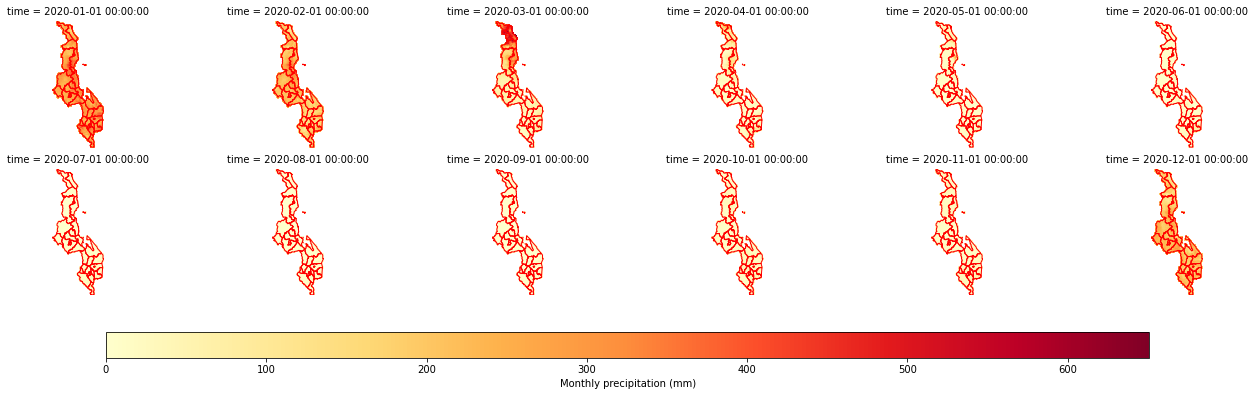

In [14]:
#show the data for each month of 2020, clipped to MWI
g=ds_clip.sel(time=ds_clip.time.dt.year.isin([2020])).precip.plot(
    col="time",
    col_wrap=6,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
        "label":"Monthly precipitation (mm)"
    },
    cmap="YlOrRd",
)

df_bound = gpd.read_file(adm2_bound_path)
for ax in g.axes.flat:
    df_bound.boundary.plot(linewidth=1, ax=ax, color="red")
    ax.axis("off")

In [15]:
#should already sorted by date, but just to be sure before applying rolling
ds_clip=ds_clip.sortby("time")

In [16]:
#compute the rolling sum over three month period. Rolling sum works backwards, i.e. value for month 3 is sum of month 1 till 3
seas_len=3
ds_season=ds_clip.rolling(time=seas_len,min_periods=seas_len).sum().dropna(dim="time",how="all")

In [17]:
ds_season

<xarray.Dataset>
Dimensions:      (lat: 156, lon: 66, time: 479)
Coordinates:
  * time         (time) object 1981-03-01 00:00:00 ... 2021-01-01 00:00:00
  * lat          (lat) float64 -9.375 -9.425 -9.475 ... -17.02 -17.07 -17.12
  * lon          (lon) float64 32.68 32.73 32.78 32.83 ... 35.83 35.88 35.93
    spatial_ref  int64 0
Data variables:
    precip       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    latitude#axis:                            Y
    latitude#long_name:                       latitude
    latitude#standard_name:                   latitude
    latitude#units:                           degrees_north
    latitude#_FillValue:                      nan
    longitude#axis:                           X
    longitude#long_name:                      longitude
    longitude#standard_name:                  longitude
    longitude#units:                          degrees_east
    longitude#_FillValue:                     nan
    acknowledgements:                         The Climate Hazards Group Infra...
    comments:                                 time variable denotes the first...
    Conventions:                              CF-1.6
    creator_email:                            pete@geog.ucsb.edu
    creator_name:                             Pete Peterson
    date_created:                             2021-02-16
    documentation:                            http://pubs.usgs.gov/ds/832/
    faq:                                      http://chg-wiki.geog.ucsb.edu/w...
    ftp_url:                                  ftp://chg-ftpout.geog.ucsb.edu/...
    grid_mapping:                             spatial_ref
    history:                                  created by Climate Hazards Group
    institution:                              Climate Hazards Group.  Univers...
    reference:                                Funk, C.C., Peterson, P.J., Lan...
    title:                                    CHIRPS Version 2.0
    version:                                  Version 2.0
    website:                                  http://chg.geog.ucsb.edu/data/c...
    NETCDF_DIM_EXTRA:                         {time}
    NETCDF_DIM_time_DEF:                      [481.   5.]
    NETCDF_DIM_time_VALUES:                   [  366.   397.   425.   456.   ...
    precip#coordinates:                       spatial_ref
    precip#geostatial_lat_max:                50
    precip#geostatial_lat_min:                -50
    precip#geostatial_lon_max:                180
    precip#geostatial_lon_min:                -180
    precip#grid_mapping:                      spatial_ref
    precip#long_name:                         Climate Hazards group InfraRed ...
    precip#missing_value:                     -9999
    precip#standard_name:                     convective precipitation rate
    precip#time_step:                         month
    precip#units:                             mm/month
    precip#_FillValue:                        -9999
    spatial_ref#crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984...
    spatial_ref#geographic_crs_name:          WGS 84
    spatial_ref#GeoTransform:                 32.650003051757814 0.05 0.0 -17...
    spatial_ref#grid_mapping_name:            latitude_longitude
    spatial_ref#inverse_flattening:           298.257223563
    spatial_ref#longitude_of_prime_meridian:  0
    spatial_ref#prime_meridian_name:          Greenwich
    spatial_ref#reference_ellipsoid_name:     WGS 84
    spatial_ref#semi_major_axis:              6378137
    spatial_ref#semi_minor_axis:              6356752.314245179
    spatial_ref#spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984...
    time#axis:                                T
    time#calendar:                            gregorian
    time#standard_name:                       time
    time#units:                               days since 1980-01-01
    time#_FillValue:                          nan

In [18]:
#check dense spot for other dates

<Figure size 432x288 with 0 Axes>

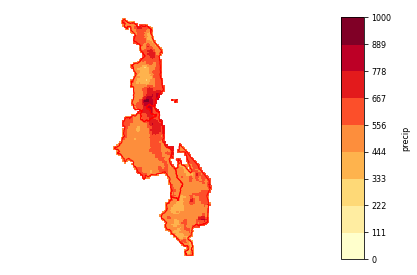

In [19]:
#plot the three month sum for NDJ 2019/2020
fig=plot_raster_boundaries_clip([ds_season.rio.set_spatial_dims(x_dim=config.LONGITUDE, y_dim=config.LATITUDE).rio.write_crs("EPSG:4326").sel(time=test_date)],adm1_bound_path,colp_num=1,forec_val="precip",cmap="YlOrRd",predef_bins=np.linspace(0,1000,10))

In [20]:
#adjust climatological period - experiment

In [21]:
#define the years that are used to define the climatology. We use 1981-2010 since this is also the period used by IRI's seasonal forecasts
ds_season_climate=ds_season.sel(time=ds_season.time.dt.year.isin(range(1981,2011)))

In [22]:
ds_season_climate

<xarray.Dataset>
Dimensions:      (lat: 156, lon: 66, time: 358)
Coordinates:
  * time         (time) object 1981-03-01 00:00:00 ... 2010-12-01 00:00:00
  * lat          (lat) float64 -9.375 -9.425 -9.475 ... -17.02 -17.07 -17.12
  * lon          (lon) float64 32.68 32.73 32.78 32.83 ... 35.83 35.88 35.93
    spatial_ref  int64 0
Data variables:
    precip       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    latitude#axis:                            Y
    latitude#long_name:                       latitude
    latitude#standard_name:                   latitude
    latitude#units:                           degrees_north
    latitude#_FillValue:                      nan
    longitude#axis:                           X
    longitude#long_name:                      longitude
    longitude#standard_name:                  longitude
    longitude#units:                          degrees_east
    longitude#_FillValue:                     nan
    acknowledgements:                         The Climate Hazards Group Infra...
    comments:                                 time variable denotes the first...
    Conventions:                              CF-1.6
    creator_email:                            pete@geog.ucsb.edu
    creator_name:                             Pete Peterson
    date_created:                             2021-02-16
    documentation:                            http://pubs.usgs.gov/ds/832/
    faq:                                      http://chg-wiki.geog.ucsb.edu/w...
    ftp_url:                                  ftp://chg-ftpout.geog.ucsb.edu/...
    grid_mapping:                             spatial_ref
    history:                                  created by Climate Hazards Group
    institution:                              Climate Hazards Group.  Univers...
    reference:                                Funk, C.C., Peterson, P.J., Lan...
    title:                                    CHIRPS Version 2.0
    version:                                  Version 2.0
    website:                                  http://chg.geog.ucsb.edu/data/c...
    NETCDF_DIM_EXTRA:                         {time}
    NETCDF_DIM_time_DEF:                      [481.   5.]
    NETCDF_DIM_time_VALUES:                   [  366.   397.   425.   456.   ...
    precip#coordinates:                       spatial_ref
    precip#geostatial_lat_max:                50
    precip#geostatial_lat_min:                -50
    precip#geostatial_lon_max:                180
    precip#geostatial_lon_min:                -180
    precip#grid_mapping:                      spatial_ref
    precip#long_name:                         Climate Hazards group InfraRed ...
    precip#missing_value:                     -9999
    precip#standard_name:                     convective precipitation rate
    precip#time_step:                         month
    precip#units:                             mm/month
    precip#_FillValue:                        -9999
    spatial_ref#crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984...
    spatial_ref#geographic_crs_name:          WGS 84
    spatial_ref#GeoTransform:                 32.650003051757814 0.05 0.0 -17...
    spatial_ref#grid_mapping_name:            latitude_longitude
    spatial_ref#inverse_flattening:           298.257223563
    spatial_ref#longitude_of_prime_meridian:  0
    spatial_ref#prime_meridian_name:          Greenwich
    spatial_ref#reference_ellipsoid_name:     WGS 84
    spatial_ref#semi_major_axis:              6378137
    spatial_ref#semi_minor_axis:              6356752.314245179
    spatial_ref#spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984...
    time#axis:                                T
    time#calendar:                            gregorian
    time#standard_name:                       time
    time#units:                               days since 1980-01-01
    time#_FillValue:                          nan

In [23]:
#compute the thresholds for the lower tercile, i.e. below average, per season
#since we computed a rolling sum, each month represents a season
ds_season_climate_quantile=ds_season_climate.groupby(ds_season_climate.time.dt.month).quantile(0.33)

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [24]:
ds_season_climate_quantile

<xarray.Dataset>
Dimensions:   (lat: 156, lon: 66, month: 12)
Coordinates:
  * lat       (lat) float64 -9.375 -9.425 -9.475 -9.525 ... -17.02 -17.07 -17.12
  * lon       (lon) float64 32.68 32.73 32.78 32.83 ... 35.78 35.83 35.88 35.93
    quantile  float64 0.33
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip    (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [25]:
#hotspot check

<Figure size 432x288 with 0 Axes>

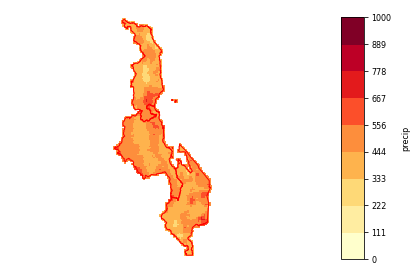

In [26]:
#plot the below average boundaries for the NDJ season
fig=plot_raster_boundaries_clip([ds_season_climate_quantile.rio.set_spatial_dims(x_dim=config.LONGITUDE, y_dim=config.LATITUDE).rio.write_crs("EPSG:4326").sel(month=1)],adm1_bound_path,colp_num=1,forec_val="precip",predef_bins=np.linspace(0,1000,10),cmap="YlOrRd")

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

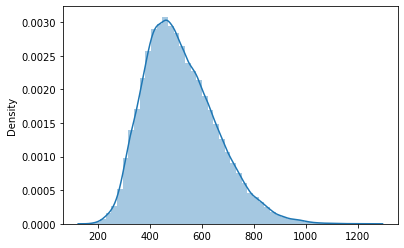

In [27]:
sns.distplot(ds_season_climate.sel(time=ds_season_climate.time.dt.month==1).precip.values.flatten())

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

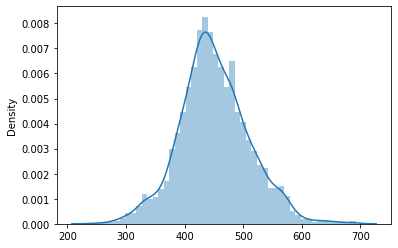

In [28]:
sns.distplot(ds_season_climate_quantile.sel(month=1).precip.values.flatten())

In [29]:
# possibly change -999

In [30]:
#determine the raster cells that have below-average precipitation, other cells are set to -999
list_ds_seass=[]
for s in np.unique(ds_season.time.dt.month):
    ds_seas_sel=ds_season.sel(time=ds_season.time.dt.month==s)
    #keep original values of cells that are either nan or have below average precipitation, all others are set to -999
    ds_seas_below=ds_seas_sel.where((ds_seas_sel.precip.isnull())|(ds_seas_sel.precip<=ds_season_climate_quantile.sel(month=s).precip),-999)#,drop=True)
    list_ds_seass.append(ds_seas_below)
ds_season_below=xr.concat(list_ds_seass,dim="time")        

In [31]:
ds_season_below

<xarray.Dataset>
Dimensions:      (lat: 156, lon: 66, time: 479)
Coordinates:
  * time         (time) object 1982-01-01 00:00:00 ... 2020-12-01 00:00:00
  * lat          (lat) float64 -9.375 -9.425 -9.475 ... -17.02 -17.07 -17.12
  * lon          (lon) float64 32.68 32.73 32.78 32.83 ... 35.83 35.88 35.93
    spatial_ref  int64 0
    quantile     float64 0.33
    month        (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
Data variables:
    precip       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    latitude#axis:                            Y
    latitude#long_name:                       latitude
    latitude#standard_name:                   latitude
    latitude#units:                           degrees_north
    latitude#_FillValue:                      nan
    longitude#axis:                           X
    longitude#long_name:                      longitude
    longitude#standard_name:                  longitude
    longitude#units:                          degrees_east
    longitude#_FillValue:                     nan
    acknowledgements:                         The Climate Hazards Group Infra...
    comments:                                 time variable denotes the first...
    Conventions:                              CF-1.6
    creator_email:                            pete@geog.ucsb.edu
    creator_name:                             Pete Peterson
    date_created:                             2021-02-16
    documentation:                            http://pubs.usgs.gov/ds/832/
    faq:                                      http://chg-wiki.geog.ucsb.edu/w...
    ftp_url:                                  ftp://chg-ftpout.geog.ucsb.edu/...
    grid_mapping:                             spatial_ref
    history:                                  created by Climate Hazards Group
    institution:                              Climate Hazards Group.  Univers...
    reference:                                Funk, C.C., Peterson, P.J., Lan...
    title:                                    CHIRPS Version 2.0
    version:                                  Version 2.0
    website:                                  http://chg.geog.ucsb.edu/data/c...
    NETCDF_DIM_EXTRA:                         {time}
    NETCDF_DIM_time_DEF:                      [481.   5.]
    NETCDF_DIM_time_VALUES:                   [  366.   397.   425.   456.   ...
    precip#coordinates:                       spatial_ref
    precip#geostatial_lat_max:                50
    precip#geostatial_lat_min:                -50
    precip#geostatial_lon_max:                180
    precip#geostatial_lon_min:                -180
    precip#grid_mapping:                      spatial_ref
    precip#long_name:                         Climate Hazards group InfraRed ...
    precip#missing_value:                     -9999
    precip#standard_name:                     convective precipitation rate
    precip#time_step:                         month
    precip#units:                             mm/month
    precip#_FillValue:                        -9999
    spatial_ref#crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984...
    spatial_ref#geographic_crs_name:          WGS 84
    spatial_ref#GeoTransform:                 32.650003051757814 0.05 0.0 -17...
    spatial_ref#grid_mapping_name:            latitude_longitude
    spatial_ref#inverse_flattening:           298.257223563
    spatial_ref#longitude_of_prime_meridian:  0
    spatial_ref#prime_meridian_name:          Greenwich
    spatial_ref#reference_ellipsoid_name:     WGS 84
    spatial_ref#semi_major_axis:              6378137
    spatial_ref#semi_minor_axis:              6356752.314245179
    spatial_ref#spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984...
    time#axis:                                T
    time#calendar:                            gregorian
    time#standard_name:                       time
    time#units:                               days

In [32]:
# #can be used to inspect the values that are below average
# with np.printoptions(threshold=np.inf):
#     print(np.unique(ds_season_below.sel(time=test_date)["precip"].values.flatten()[~np.isnan(ds_season_below.sel(time=test_date)["precip"].values.flatten())]))

In [33]:
#fraction of values with below average value. Should be around 0.33
ds_season_below_notnan=ds_season_below.precip.values[~np.isnan(ds_season_below.precip.values)]
np.count_nonzero(ds_season_below_notnan!=-999)/np.count_nonzero(ds_season_below_notnan)

0.31794414082721123

In [34]:
#check occurence below average per raster cell
#compute #times each category
#geographical autocorrelation

<Figure size 432x288 with 0 Axes>

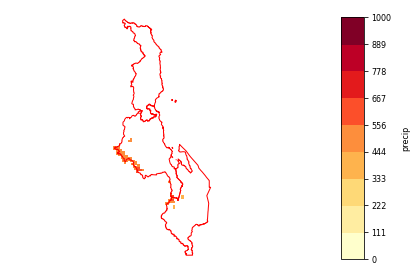

In [35]:
#plot the cells that had below-average rainfall in NDJ of 2019/2020
fig=plot_raster_boundaries_clip([ds_season_below.where(ds_season_below.precip!=-999).rio.set_spatial_dims(x_dim=config.LONGITUDE, y_dim=config.LATITUDE).rio.write_crs("EPSG:4326").sel(time=test_date)],adm1_bound_path,colp_num=1,forec_val="precip",cmap="YlOrRd",predef_bins=np.linspace(0,1000,10))

In [36]:
#usual center point

In [37]:
#resolution forecasts--> interpolate (or vectorize)
#Do lots of CRS checks! 
#test different thresholds percentage area
#forecast: weighted average or >%area above threshold

In [38]:
def alldates_statistics_seasonal(ds,raster_transform,adm_path):
    #compute statistics on level in adm_path for all dates in ds
    df_list=[]
    for date in ds.time.values:
        df=gpd.read_file(adm_path)
        ds_date=ds.sel(time=date)
        
        # compute the percentage of the admin area that has below average rainfall
        #set all values with below average rainfall to 1 and others to 0
        forecast_binary = np.where(ds_date.precip.values!=-999, 1, 0)
        #compute number of cells in admin region (sum) and number of cells in admin region with below average rainfall (count)
        bin_zonal = pd.DataFrame(
            zonal_stats(vectors=df, raster=forecast_binary, affine=raster_transform, stats=['count', 'sum'],nodata=np.nan))
        df['perc_threshold'] = bin_zonal['sum'] / bin_zonal['count'] * 100
        
        #same but then also including cells that only touch the admin region, i.e. don't have their cell within that region
        bin_zonal_touched = pd.DataFrame(
            zonal_stats(vectors=df, raster=forecast_binary, affine=raster_transform, all_touched=True, stats=['count', 'sum'],nodata=np.nan))
        df['perc_threshold_touched'] = bin_zonal_touched['sum'] / bin_zonal_touched['count'] * 100
        
        #return the value of the cell with the highest value within the admin region. 
        #In our case if this isn't -999 it indicates that at least one cell has below average rainfall
        df["max_cell_touched"] = pd.DataFrame(
        zonal_stats(vectors=df, raster=ds_date["precip"].values, affine=raster_transform, all_touched=True,nodata=np.nan))["max"]
        df["max_cell"] = pd.DataFrame(
        zonal_stats(vectors=df, raster=ds_date["precip"].values, affine=raster_transform, nodata=np.nan))["max"]
        
        df["date"]=pd.to_datetime(date.strftime("%Y-%m-%d"))
  
        df_list.append(df)
    df_hist=pd.concat(df_list)
    df_hist=df_hist.sort_values(by="date")
    #all admins that are not -999, have at least one cell with below average rainfall
    df_hist[f"below_average_touched"]=np.where(df_hist["max_cell_touched"]!=-999,1,0)
    df_hist[f"below_average_max"]=np.where(df_hist["max_cell"]!=-999,1,0)
        
    df_hist["date_str"]=df_hist["date"].dt.strftime("%Y-%m")
    df_hist['date_month']=df_hist.date.dt.to_period("M")
        
    return df_hist

In [39]:
ds_season_below.rio.crs

CRS.from_epsg(4326)

In [40]:
ds_season_below.rio.transform()

Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)

In [41]:
ds_season_below.rio.set_spatial_dims(x_dim="lon",y_dim="lat").rio.write_crs("EPSG:4326").rio.transform()

Affine(0.05, 0.0, 32.650003051757814,
       0.0, -0.05, -9.35)

In [42]:
#compute whether the maximum cell that touches an admin2 region has below average rainfall for each month since 2010
#have to write the crs for the transform to be correct!
df_belowavg_seas=alldates_statistics_seasonal(ds_season_below.sel(time=ds_season_below.time.dt.year.isin(range(2010,2021))),ds_season_below.rio.set_spatial_dims(x_dim="lon",y_dim="lat").rio.write_crs("EPSG:4326").rio.transform(),adm2_bound_path)

In [43]:
# #quality check
# #check that all max touched values in df_belowavg_seas are also present in ds_season_below
# #this is to make sure all goes correctly with zonal_stats regarding crs's since it has happened that things go wrong there without insight why
# display(df_belowavg_seas[df_belowavg_seas.date==test_date_dtime])
# with np.printoptions(threshold=np.inf):
#     print(np.unique(ds_season_below.sel(time=test_date)["precip"].values.flatten()[~np.isnan(ds_season_below.sel(time=test_date)["precip"].values.flatten())]))

In [44]:
#percentage of area with below average rain
#TODO: decide which threshold to use
#could argue for 50%, i.e. majority
#could also argue for 30% as this results in around 1/3 of the occurences the area being below average, which is the definition of terciles. 
#Don't know if large difference between adm regions
#Note: only including cells that have their centre within the region, do think this makes sense especially with the high resolution we got
for i in np.linspace(0,100,11):
    print(f"Fraction of adm2-date combinations where >={i}% of area received bel. avg. rain:","{:.2f}".format(len(df_belowavg_seas[df_belowavg_seas["perc_threshold"]>=i])/len(df_belowavg_seas)))

Fraction of adm2-date combinations where >=0.0% of area received bel. avg. rain: 1.00
Fraction of adm2-date combinations where >=10.0% of area received bel. avg. rain: 0.43
Fraction of adm2-date combinations where >=20.0% of area received bel. avg. rain: 0.37
Fraction of adm2-date combinations where >=30.0% of area received bel. avg. rain: 0.33
Fraction of adm2-date combinations where >=40.0% of area received bel. avg. rain: 0.29
Fraction of adm2-date combinations where >=50.0% of area received bel. avg. rain: 0.27
Fraction of adm2-date combinations where >=60.0% of area received bel. avg. rain: 0.24
Fraction of adm2-date combinations where >=70.0% of area received bel. avg. rain: 0.22
Fraction of adm2-date combinations where >=80.0% of area received bel. avg. rain: 0.20
Fraction of adm2-date combinations where >=90.0% of area received bel. avg. rain: 0.17
Fraction of adm2-date combinations where >=100.0% of area received bel. avg. rain: 0.12


In [45]:
#This is when assigning the whole adm2 region as below average when any cell touching has below average rainfall 
#--> logical that it is a larger fraction than the climatological 0.33
print("fraction of adm2s with at least one cell with below average rain:",len(df_belowavg_seas[df_belowavg_seas["below_average_max"]==1])/len(df_belowavg_seas))

fraction of adm2s with at least one cell with below average rain: 0.5490056818181818


In [46]:
#for now using 0.30 as threshold
df_belowavg_seas["below_average"]=np.where(df_belowavg_seas["perc_threshold"]>=30,1,0)

In [47]:
#Hmm surprised that there is such a large difference across months.. Would want them to all be around 0.33?
#compute fraction of values having below average per month
df_bavg_month=df_belowavg_seas.groupby(df_belowavg_seas.date.dt.month).sum()
df_bavg_month['fract_below']=df_bavg_month["below_average"]/df_belowavg_seas.groupby(df_belowavg_seas.date.dt.month).count()["below_average"]
df_bavg_month[["fract_below"]]

,fract_below
date,
1,0.272727
2,0.335227
3,0.463068
4,0.409091
5,0.340909
6,0.170455
7,0.196023
8,0.329545
9,0.383523


In [48]:
#compute fraction of values having below average per year
df_bavg_year=df_belowavg_seas.groupby(df_belowavg_seas.date.dt.year).sum()
df_bavg_year['fract_below']=df_bavg_year["below_average"]/df_belowavg_seas.groupby(df_belowavg_seas.date.dt.year).count()["below_average"]
df_bavg_year[["fract_below"]]

,fract_below
date,
2010,0.359375
2011,0.328125
2012,0.338542
2013,0.289062
2014,0.320312
2015,0.567708
2016,0.440104
2017,0.184896
2018,0.208333


In [49]:
#seems the deviation from 0.33 is not crazy large for any adm2 and not clear dependency on the size of the adm2
#compute fraction of values having below average per ADMIN2
df_bavg_adm2=df_belowavg_seas.groupby("ADM2_EN").sum()
df_bavg_adm2["fract_below"]=df_bavg_adm2["below_average"]/df_belowavg_seas.groupby("ADM2_EN").count()["below_average"]
df_bavg_adm2[["fract_below","Shape_Area"]]

,fract_below,Shape_Area
ADM2_EN,,
Balaka,0.287879,23.678031
Blantyre,0.416667,19.911794
Blantyre City,0.424242,2.630634
Chikwawa,0.280303,54.576276
Chiradzulu,0.378788,8.463457
Chitipa,0.242424,46.262954
Dedza,0.272727,41.575315
Dowa,0.348485,33.790189
Karonga,0.181818,37.153565


In [50]:
#Currently not being used
# #mapping of month to season. Computed by rolling sum, i.e. month indicates last month of season
# seasons_rolling={3:"JFM",4:"FMA",5:"MAM",6:"AMJ",7:"MJJ",8:"JJA",9:"JAS",10:"ASO",11:"SON",12:"OND",1:"NDJ",2:"DJF"}

### Observed dryspells and correlation with seasonal below-average rainfall
Process the observed dryspell list as outputed by `malawi/scripts/mwi_chirps_dry_spell_detection.R` and correlate the occurence of a dry spell with below-average seasonal rainfall

As first analysis we are focussing on the sole occurence of a dry spell per admin2. This can be extended to e.g. duration, number of dry spells, and geographical spread

In [51]:
country_data_processed_dir = os.path.join(config.DATA_DIR,config.PROCESSED_DIR,country)

In [52]:
# df_ds=pd.read_csv(os.path.join(country_data_exploration_dir,"dryspells","mwi_dry_spells_list.csv")) #"../Data/transformed/mwi_dry_spells_list.csv")
df_ds=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","dry_spells_during_rainy_season_list.csv")) 

In [53]:
df_ds

,pcode,ADM2_EN,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall
0,MW103,Nkhata Bay,2012-04-19,2012-05-02,14,0.0
1,MW103,Nkhata Bay,2018-04-17,2018-04-30,14,0.0
2,MW104,Rumphi,2012-04-18,2012-05-02,15,0.0
3,MW105,Mzimba,2012-04-19,2012-05-04,16,0.0
4,MW107,Mzuzu City,2011-04-12,2011-04-30,19,0.0
...,...,...,...,...,...,...
78,MW315,Blantyre City,2011-04-10,2011-05-19,40,0.0
79,MW315,Blantyre City,2013-03-21,2013-04-03,14,0.0
80,MW315,Blantyre City,2015-04-01,2015-04-14,14,0.0
81,MW315,Blantyre City,2019-03-21,2019-04-16,27,0.0


In [54]:
df_ds["dry_spell_first_date"]=pd.to_datetime(df_ds["dry_spell_first_date"])
df_ds["dry_spell_last_date"]=pd.to_datetime(df_ds["dry_spell_last_date"])
df_ds["ds_fd_m"]=df_ds.dry_spell_first_date.dt.to_period("M")

In [55]:
#for now only want to know if a dry spell occured in a given month, so drop those that have several dry spells confirmed within a month
df_ds_drymonth=df_ds.drop_duplicates(["ADM2_EN","ds_fd_m"]).groupby(["ds_fd_m","ADM2_EN"],as_index=False).agg("count")[["ds_fd_m","ADM2_EN","dry_spell_first_date"]] #["ADM2_EN"]

In [56]:
#include all dates present in the observed rainfall df but not in the dry spell list, i.e. where no dryspells were observed
df_ds_drymonth_alldates=df_ds_drymonth.merge(df_belowavg_seas[["ADM2_EN","date_month"]],how="outer",left_on=['ADM2_EN','ds_fd_m'],right_on=["ADM2_EN","date_month"])

In [57]:
#dates that are not present in the dry spell list, but are in the observed rainfall df, thus have no dry spells
df_ds_drymonth_alldates.dry_spell_first_date=df_ds_drymonth_alldates.dry_spell_first_date.replace(np.nan,0)

In [58]:
#compute the rolling sum of months having a dry spell per admin2
s_ds_dryseas=df_ds_drymonth_alldates.sort_values("date_month").set_index("date_month").groupby('ADM2_EN')['dry_spell_first_date'].rolling(3).sum()
#convert series to dataframe
df_ds_dryseas=pd.DataFrame(s_ds_dryseas).reset_index()

In [59]:
df_ds_dryseas

,ADM2_EN,date_month,dry_spell_first_date
0,Balaka,2010-01,NaN
1,Balaka,2010-02,NaN
2,Balaka,2010-03,0.0
3,Balaka,2010-04,0.0
4,Balaka,2010-05,0.0
...,...,...,...
4219,Zomba City,2020-08,0.0
4220,Zomba City,2020-09,0.0
4221,Zomba City,2020-10,0.0
4222,Zomba City,2020-11,0.0


In [60]:
#supposed length of df_ds_dryseas
#TODO: check discrepancy
11*12*len(df_ds.ADM2_EN.unique())

3828

In [61]:
#merge the dry spells with the info if a month had below average rainfall
#merge on outer such that all dates present in one of the two are included
df_comb_seas=df_ds_dryseas.merge(df_belowavg_seas,how="outer",on=["date_month","ADM2_EN"])

In [62]:
#remove dates where dry_spell_confirmation is nan, i.e. where rolling sum could not be computed for (first dates)
df_comb_seas=df_comb_seas[df_comb_seas.dry_spell_first_date.notna()]

In [63]:
#set the occurence of a dry spell to true if in at least one of the months of the season (=3 months) a dry spell occured
df_comb_seas["dry_spell"]=np.where(df_comb_seas.dry_spell_first_date>=1,1,0)

In [64]:
df_comb_seas.head()

,ADM2_EN,date_month,dry_spell_first_date,Shape_Leng,Shape_Area,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,...,geometry,perc_threshold,perc_threshold_touched,max_cell_touched,max_cell,below_average_touched,below_average_max,date_str,below_average,dry_spell
2,Balaka,2010-03,0.0,2.036817,0.179379,MW312,None,None,None,Southern,...,"POLYGON ((35.20154 -14.75811, 35.20882 -14.768...",19.178082,24.210526,585.188744,547.666367,1,1,2010-03,0,0
3,Balaka,2010-04,0.0,2.036817,0.179379,MW312,None,None,None,Southern,...,"POLYGON ((35.20154 -14.75811, 35.20882 -14.768...",0.000000,0.000000,-999.000000,-999.000000,0,0,2010-04,0,0
4,Balaka,2010-05,0.0,2.036817,0.179379,MW312,None,None,None,Southern,...,"POLYGON ((35.20154 -14.75811, 35.20882 -14.768...",60.273973,60.000000,178.679901,158.966997,1,1,2010-05,1,0
5,Balaka,2010-06,0.0,2.036817,0.179379,MW312,None,None,None,Southern,...,"POLYGON ((35.20154 -14.75811, 35.20882 -14.768...",0.000000,0.000000,-999.000000,-999.000000,0,0,2010-06,0,0
6,Balaka,2010-07,0.0,2.036817,0.179379,MW312,None,None,None,Southern,...,"POLYGON ((35.20154 -14.75811, 35.20882 -14.768...",0.000000,0.000000,-999.000000,-999.000000,0,0,2010-07,0,0


[[2602 1309]
 [ 185   64]]


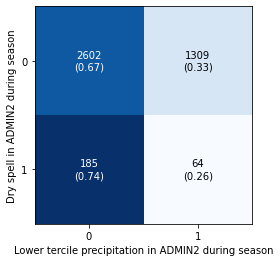

In [65]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_target =    df_comb_seas["dry_spell"]
y_predicted = df_comb_seas["below_average"]

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
ax.set_ylabel("Dry spell in ADMIN2 during season")
ax.set_xlabel("Lower tercile precipitation in ADMIN2 during season")
plt.show()

In [66]:
#TODO: define this based on rainy_seasons output R script
df_comb_seas_rainyseas=df_comb_seas[df_comb_seas.date_month.dt.month.isin([11,12,1,2,3,4])]

[[1224  731]
 [  46   47]]


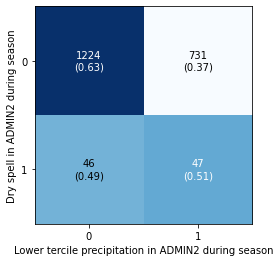

In [67]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_target =    df_comb_seas_rainyseas["dry_spell"]
y_predicted = df_comb_seas_rainyseas["below_average"]

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
ax.set_ylabel("Dry spell in ADMIN2 during season")
ax.set_xlabel("Lower tercile precipitation in ADMIN2 during season")
plt.show()

### CHIRPS monthly

In [68]:
#TODO: make sure is aligned with newest seasonal version

In [69]:
#date to make plots for to test values. To be sure this is consistent across the different plots
test_month_date=cftime.DatetimeGregorian(2020, 1, 1, 0, 0, 0, 0)
test_month_date_dtime="2020-1-1"

<Figure size 432x288 with 0 Axes>

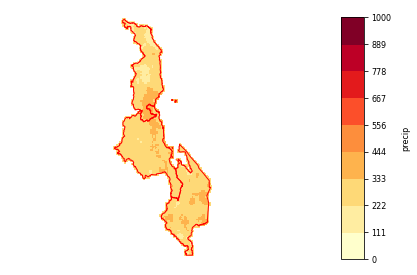

In [70]:
#plot the three month sum for NDJ 2019/2020
fig=plot_raster_boundaries_clip([ds_clip.rio.set_spatial_dims(x_dim=config.LONGITUDE, y_dim=config.LATITUDE).rio.write_crs("EPSG:4326").sel(time=test_month_date)],adm1_bound_path,colp_num=1,forec_val="precip",cmap="YlOrRd",predef_bins=np.linspace(0,1000,10))

In [71]:
#define the years that are used to define the climatology. We use 1981-2010 since this is also the period used by IRI's seasonal forecasts
ds_month_climate=ds_clip.sel(time=ds_clip.time.dt.year.isin(range(1981,2011)))

In [72]:
#compute the thresholds for the lower tercile, i.e. below average, per season
#since we computed a rolling sum, each month represents a season
ds_month_climate_quantile=ds_month_climate.groupby(ds_month_climate.time.dt.month).quantile(0.33,skipna=True)

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

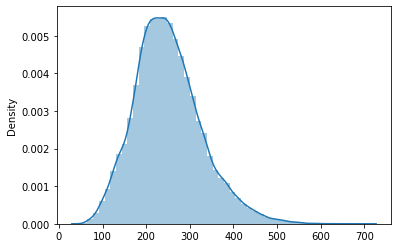

In [73]:
sns.distplot(ds_month_climate.sel(time=ds_month_climate.time.dt.month==1).precip.values.flatten())

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

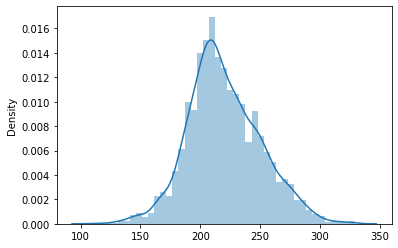

In [74]:
sns.distplot(ds_month_climate_quantile.sel(month=1).precip.values.flatten())

In [75]:
ds_month_climate_quantile

<xarray.Dataset>
Dimensions:   (lat: 156, lon: 66, month: 12)
Coordinates:
  * lat       (lat) float64 -9.375 -9.425 -9.475 -9.525 ... -17.02 -17.07 -17.12
  * lon       (lon) float64 32.68 32.73 32.78 32.83 ... 35.78 35.83 35.88 35.93
    quantile  float64 0.33
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip    (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

<Figure size 432x288 with 0 Axes>

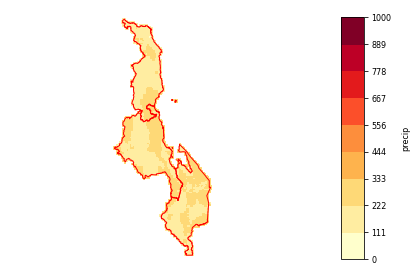

In [76]:
#plot the below average boundaries for the NDJ season
fig=plot_raster_boundaries_clip([ds_month_climate_quantile.rio.set_spatial_dims(x_dim=config.LONGITUDE, y_dim=config.LATITUDE).rio.write_crs("EPSG:4326").sel(month=1)],adm1_bound_path,colp_num=1,forec_val="precip",predef_bins=np.linspace(0,1000,10),cmap="YlOrRd")

In [77]:
#determine the raster cells that have below-average precipitation, other cells are set to -999
list_ds_months=[]
for s in np.unique(ds_clip.time.dt.month):
    ds_month_sel=ds_clip.sel(time=ds_clip.time.dt.month==s)
    #drop removes the dates with all nan values, i.e. no below average, but we dont want that
    ds_month_below=ds_month_sel.where((ds_month_sel.precip.isnull()) | (ds_month_sel.precip<=ds_month_climate_quantile.sel(month=s).precip) ,-999)
    list_ds_months.append(ds_month_below)
ds_month_below=xr.concat(list_ds_months,dim="time")        

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

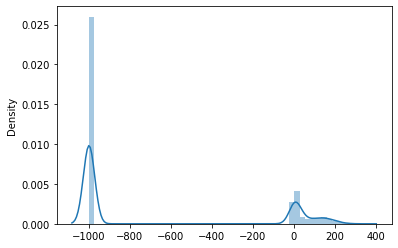

In [78]:
sns.distplot(ds_month_below.precip.values.flatten())

In [79]:
with np.printoptions(threshold=np.inf):
    print(np.unique(ds_month_below.sel(time=test_month_date)["precip"].values.flatten()[~np.isnan(ds_month_below.sel(time=test_month_date)["precip"].values.flatten())]))

[-999.          227.38040161  237.52714539  279.73336792]


In [80]:
ds_month_below_notnan=ds_month_below.precip.values[~np.isnan(ds_month_below.precip.values)]
np.count_nonzero(ds_month_below_notnan!=-999)/np.count_nonzero(ds_month_below_notnan)

0.31441205435013486

<Figure size 432x288 with 0 Axes>

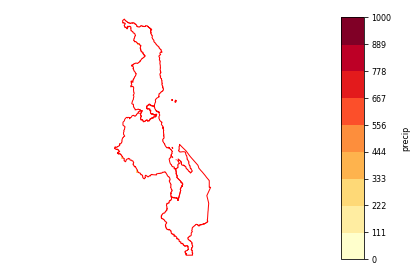

In [81]:
#not correct anymore cause using -999
#plot the cells that had below-average rainfall in DJF of 2019/2020
fig=plot_raster_boundaries_clip([ds_month_below.where(ds_month_below.precip!=-999).rio.set_spatial_dims(x_dim=config.LONGITUDE, y_dim=config.LATITUDE).rio.write_crs("EPSG:4326").sel(time=test_month_date)],adm1_bound_path,colp_num=1,forec_val="precip",cmap="YlOrRd",predef_bins=np.linspace(0,1000,10))

In [82]:
def alldates_statistics_monthly(ds,raster_transform,adm_path):
    #compute statistics on level in adm_path for all dates in ds
    df_list=[]
    for date in ds.time.values:
        df=gpd.read_file(adm_path)
        ds_date=ds.sel(time=date)
        df["max_cell_touched"] = pd.DataFrame(
        zonal_stats(vectors=df, raster=ds_date["precip"].values, affine=raster_transform, all_touched=True,nodata=np.nan))["max"]
        df["date"]=pd.to_datetime(date.strftime("%Y-%m-%d"))
        
         # calculate the percentage of the area within an geographical area that has a value larger than threshold
        forecast_binary = np.where(ds_date.precip.values!=-999, 1, 0)
        bin_zonal = pd.DataFrame(
        zonal_stats(vectors=df, raster=forecast_binary, affine=raster_transform, stats=['count', 'sum'],nodata=np.nan))
        df['perc_threshold'] = bin_zonal['sum'] / bin_zonal['count'] * 100
        bin_zonal_touched = pd.DataFrame(
            zonal_stats(vectors=df, raster=forecast_binary, affine=raster_transform, all_touched=True, stats=['count', 'sum'], nodata=np.nan))
        df['perc_threshold_touched'] = bin_zonal_touched['sum'] / bin_zonal_touched['count'] * 100
  
        df_list.append(df)
    df_hist=pd.concat(df_list)
    df_hist=df_hist.sort_values(by="date")
    #all cells that are not nan, have below average rainfall
    for m in ["max_cell_touched"]:
        df_hist[f"below_average"]=np.where(df_hist[m]!=-999,1,0)

        
   
        
    df_hist["date_str"]=df_hist["date"].dt.strftime("%Y-%m")
    df_hist['date_month']=df_hist.date.dt.to_period("M")
        
    return df_hist

In [83]:
ds_month_below.rio.transform()

Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)

In [84]:
ds_month_below

<xarray.Dataset>
Dimensions:      (lat: 156, lon: 66, time: 481)
Coordinates:
  * time         (time) object 1981-01-01 00:00:00 ... 2020-12-01 00:00:00
  * lat          (lat) float64 -9.375 -9.425 -9.475 ... -17.02 -17.07 -17.12
  * lon          (lon) float64 32.68 32.73 32.78 32.83 ... 35.83 35.88 35.93
    spatial_ref  int64 0
    quantile     float64 0.33
    month        (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
Data variables:
    precip       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    latitude#axis:                            Y
    latitude#long_name:                       latitude
    latitude#standard_name:                   latitude
    latitude#units:                           degrees_north
    latitude#_FillValue:                      nan
    longitude#axis:                           X
    longitude#long_name:                      longitude
    longitude#standard_name:                  longitude
    longitude#units:                          degrees_east
    longitude#_FillValue:                     nan
    acknowledgements:                         The Climate Hazards Group Infra...
    comments:                                 time variable denotes the first...
    Conventions:                              CF-1.6
    creator_email:                            pete@geog.ucsb.edu
    creator_name:                             Pete Peterson
    date_created:                             2021-02-16
    documentation:                            http://pubs.usgs.gov/ds/832/
    faq:                                      http://chg-wiki.geog.ucsb.edu/w...
    ftp_url:                                  ftp://chg-ftpout.geog.ucsb.edu/...
    grid_mapping:                             spatial_ref
    history:                                  created by Climate Hazards Group
    institution:                              Climate Hazards Group.  Univers...
    reference:                                Funk, C.C., Peterson, P.J., Lan...
    title:                                    CHIRPS Version 2.0
    version:                                  Version 2.0
    website:                                  http://chg.geog.ucsb.edu/data/c...
    NETCDF_DIM_EXTRA:                         {time}
    NETCDF_DIM_time_DEF:                      [481.   5.]
    NETCDF_DIM_time_VALUES:                   [  366.   397.   425.   456.   ...
    precip#coordinates:                       spatial_ref
    precip#geostatial_lat_max:                50
    precip#geostatial_lat_min:                -50
    precip#geostatial_lon_max:                180
    precip#geostatial_lon_min:                -180
    precip#grid_mapping:                      spatial_ref
    precip#long_name:                         Climate Hazards group InfraRed ...
    precip#missing_value:                     -9999
    precip#standard_name:                     convective precipitation rate
    precip#time_step:                         month
    precip#units:                             mm/month
    precip#_FillValue:                        -9999
    spatial_ref#crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984...
    spatial_ref#geographic_crs_name:          WGS 84
    spatial_ref#GeoTransform:                 32.650003051757814 0.05 0.0 -17...
    spatial_ref#grid_mapping_name:            latitude_longitude
    spatial_ref#inverse_flattening:           298.257223563
    spatial_ref#longitude_of_prime_meridian:  0
    spatial_ref#prime_meridian_name:          Greenwich
    spatial_ref#reference_ellipsoid_name:     WGS 84
    spatial_ref#semi_major_axis:              6378137
    spatial_ref#semi_minor_axis:              6356752.314245179
    spatial_ref#spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984...
    time#axis:                                T
    time#calendar:                            gregorian
    time#standard_name:                       time
    time#units:                               days

In [85]:
#compute whether the maximum cell that touches an admin2 region has below average rainfall for each month since 2010
df_belowavg_month=alldates_statistics_monthly(ds_month_below.sel(time=ds_month_below.time.dt.year.isin(range(2010,2021))),ds_month_below.rio.set_spatial_dims(x_dim="lon",y_dim="lat").rio.write_crs("EPSG:4326").rio.transform(),adm2_bound_path)

In [86]:
# #quality check
# #check that all max touched values in df_belowavg_month are also present in ds_month_below
# #this is to make sure all goes correctly with zonal_stats regarding crs's since it has happened that things go wrong there without insight why
# display(df_belowavg_month[df_belowavg_month.date==test_date_dtime])
# with np.printoptions(threshold=np.inf):
#     print(np.unique(ds_month_below.sel(time=test_month_date)["precip"].values.flatten()[~np.isnan(ds_month_below.sel(time=test_month_date)["precip"].values.flatten())]))

In [87]:
#AAARRRHHH this should be around 0.33... Nope it shouldnt since we are taking the max cell touched --> logical higher than 0.33.. However earlier on it should
#Plus problematic for correlations if this is an overestimation. Or well this depends again how we classify an adm2 with ofrecasts, and would argue for doing that according to largest area
print("fraction of observations with below average value:",len(df_belowavg_month[df_belowavg_month["below_average"]==1])/len(df_belowavg_month))

fraction of observations with below average value: 0.5596590909090909


In [88]:
#Hmm strange that there is such a large difference across months.. Should in theory all be 0.33?
#compute fraction of values having below average per month
df_bavg_month=df_belowavg_month.groupby(df_belowavg_month.date.dt.month).sum()
df_bavg_month['fract_below']=df_bavg_month["below_average"]/df_belowavg_month.groupby(df_belowavg_month.date.dt.month).count()["below_average"]
df_bavg_month[["fract_below"]]

,fract_below
date,
1,0.468750
2,0.576705
3,0.536932
4,0.397727
5,0.579545
6,0.576705
7,0.704545
8,0.593750
9,0.673295


In [89]:
#Hmm would have expected more deviation per year, e.g. I thought 2011 was very little rainfall year?
#compute fraction of values having below average per month
df_bavg_year=df_belowavg_month.groupby(df_belowavg_month.date.dt.year).sum()
df_bavg_year['fract_below']=df_bavg_year["below_average"]/df_belowavg_month.groupby(df_belowavg_month.date.dt.year).count()["below_average"]
df_bavg_year[["fract_below"]]

,fract_below
date,
2010,0.549479
2011,0.489583
2012,0.546875
2013,0.578125
2014,0.578125
2015,0.721354
2016,0.645833
2017,0.518229
2018,0.414062


In [90]:
#compute fraction of values having below average per ADMIN2
df_bavg_adm2=df_belowavg_month.groupby("ADM2_EN").sum()
df_bavg_adm2["fract_below"]=df_bavg_adm2["below_average"]/df_belowavg_month.groupby("ADM2_EN").count()["below_average"]
df_bavg_adm2[["fract_below"]]

,fract_below
ADM2_EN,
Balaka,0.454545
Blantyre,0.598485
Blantyre City,0.469697
Chikwawa,0.583333
Chiradzulu,0.522727
Chitipa,0.674242
Dedza,0.681818
Dowa,0.659091
Karonga,0.553030


### Quality checks

#### Compare computed 3 month sum to that reported directly by CHIRPS
AAAAHHH There are large differences and I don't understand why... 
- The 3monthly data for Global and Africa don't correspond at all, also not when inspecting it in QGIS
- The 3monthly Global data clipped to MWI is not in the same range as the 3 month rolling sum
- The 3monthly Africa data clipped to MWI is in the same range, but doesn't equal the 3 month rolling sum


Leaving it as it is for now and summing the monthly data to 3 months ourselves since this is an easier to use format. However should at some point understand the differences.. 

In [91]:
ds_chirps_3month=rioxarray.open_rasterio("../Data/chirps.3monthly.africa2019.111201.tiff",masked=True)
# ds_chirps_3month=rioxarray.open_rasterio("../Data/chirps.3monthly.africa2019.091011.tiff",masked=True)
# ds_chirps_3month=rioxarray.open_rasterio("../Data/chirps.3monthly.global2019.111201.tiff",masked=True)
# ds_chirps_3month=rioxarray.open_rasterio("../Data/chirps.3monthly.global2019.091011.tiff",masked=True)

In [92]:
ds_chirps_3month=ds_chirps_3month.where(ds_chirps_3month.values!=-9999)

In [93]:
ds_chirps_3month_mwi = ds_chirps_3month.rio.clip(df_bound.geometry.apply(mapping), df_bound.crs, all_touched=True)

In [94]:
#3 monthly mean from chirps ftp
ds_chirps_3month_mwi.mean()

<xarray.DataArray ()>
array(595.59216897)
Coordinates:
    spatial_ref  int64 0

In [95]:
#computed mean from our framework
ds_season.sel(time=cftime.DatetimeGregorian(2020, 1, 1, 0, 0, 0, 0)).precip.mean()
# ds_season.sel(time=cftime.DatetimeGregorian(2019, 11, 1, 0, 0, 0, 0)).precip.mean()

<xarray.DataArray 'precip' ()>
array(541.69499912)
Coordinates:
    time         object 2020-01-01 00:00:00
    spatial_ref  int64 0

### IRI CAMS-OPI observed monthly terciles
**First wanted to use this source for computation of historical below avearge, but now we also got CHIRPS which has a higher resolution and is the ssame source as we used for computing the dry spells, I think it makes more sense to use that data**

The percentile data is downloaded from [IRI's Maproom](https://iridl.ldeo.columbia.edu/maproom/Global/Precipitation/Percentiles.html?bbox=bb%3A-20%3A-40%3A55%3A40%3Abb&T=Dec%202020)   
The percentiles are computed from the CAMS-OPI data. The period of 1981-2010 is used to define the climatology for each calendar month of the year. A dry mask is included for regions that receive less than 10 mm/month of precipitation on average in the 1981-2010 climatology for the month of the year.    

Somehow the resolution is very low, while the original CAMS-OPI dataset has a higher resolution. I don't know what the reason of this is though for the exploration it should be good enough


In [96]:
# #would be great to do with opendap but couldn't find the right url.. 
# obs_tercile_url="http://iridl.ldeo.columbia.edu/ds:/SOURCES/.NOAA/.NCEP/.CPC/.CAMS_OPI/.v0208/.mean/.prcp/prcp_percentiles/dods"
# obs_tercile_url="http://iridl.ldeo.columbia.edu/ds:/SOURCES/.NOAA/.NCEP/.CPC/.CAMS_OPI/.v0208/.mean/.prcp/dup/T/%28Jan%201981%29%28Dec%202010%29RANGE/T/12/splitstreamgrid%5BT2%5D0.0/0.1/0.2/0.3/0.4/0.5/0.6/0.7/0.8/0.9/1.0/1.0/replacebypercentile%5Bpercentile%5Dboundedtablefunction/startcolormap/DATA/0/1/RANGE/white/sienna/sienna/0/VALUE/sienna/0.1/bandmax/tan/RGBdup/0.2/bandmax/white/white/0.8/bandmax/PaleGreen/RGBdup/0.9/bandmax/DarkGreen/RGBdup/1.0/bandmax/RGBdup/endcolormap//name//prcp_percentiles/def//long_name/%28Precipitation%20Percentiles%20%28brown%20below%2020th%20and%20green%20above%2080th%29%29def/SOURCES/.NOAA/.NCEP/.CPC/.CAMS_OPI/.v0208/.mean/.prcp/T/%28Jan%201981%29%28Dec%202010%29RANGE/T/%28days%20since%201960-01-01%29streamgridunitconvert/T/differential_mul/T/%28months%20since%201960-01-01%29streamgridunitconvert//units/%28mm/month%29def/yearly-climatology/10/flaglt%5BT%5DregridAverage//name//dry_mask/def/:ds/prcp_percentiles/dods"
# xr.open_dataset(obs_tercile_url)

In [97]:
# #only need to run if you want to update the data
# obs_tercile_netcdf_url="http://iridl.ldeo.columbia.edu/ds:/SOURCES/.NOAA/.NCEP/.CPC/.CAMS_OPI/.v0208/.mean/.prcp/dup/T/%28Jan%201981%29%28Dec%202010%29RANGE/T/12/splitstreamgrid%5BT2%5D0.0/0.1/0.2/0.3/0.4/0.5/0.6/0.7/0.8/0.9/1.0/1.0/replacebypercentile%5Bpercentile%5Dboundedtablefunction/startcolormap/DATA/0/1/RANGE/white/sienna/sienna/0/VALUE/sienna/0.1/bandmax/tan/RGBdup/0.2/bandmax/white/white/0.8/bandmax/PaleGreen/RGBdup/0.9/bandmax/DarkGreen/RGBdup/1.0/bandmax/RGBdup/endcolormap//name//prcp_percentiles/def//long_name/%28Precipitation%20Percentiles%20%28brown%20below%2020th%20and%20green%20above%2080th%29%29def/SOURCES/.NOAA/.NCEP/.CPC/.CAMS_OPI/.v0208/.mean/.prcp/T/%28Jan%201981%29%28Dec%202010%29RANGE/T/%28days%20since%201960-01-01%29streamgridunitconvert/T/differential_mul/T/%28months%20since%201960-01-01%29streamgridunitconvert//units/%28mm/month%29def/yearly-climatology/10/flaglt%5BT%5DregridAverage//name//dry_mask/def/:ds/prcp_percentiles/data.nc"
# download_url(obs_tercile_netcdf_url,cams_tercile_path)

In [98]:
terc_ds=xr.open_dataset(cams_tercile_path,decode_times=False)
terc_ds=terc_ds.rename({"X":"lon","Y":"lat"})
terc_ds=fix_calendar(terc_ds,timevar="T")
terc_ds = xr.decode_cf(terc_ds)
terc_ds = invert_latlon(terc_ds)

# AAARGHH apparently for this data I shouldn't adjust the longitude range, while for the rainfall forecasts it seemed essential
# and I have no clue what might cause this difference. Possibly also connected to the shapefile??
#This is essential for the rasterstats.zonal_stats, and I still don't fully understand what the format is that it needs
#But if it is not correct, it overlays the shapefile with another part of the world and thus the results can be completely off..
# terc_ds = change_longitude_range(terc_ds)

In [99]:
#check again with this new methodology of computing the transform of the ds

In [100]:
transform=terc_ds.rio.transform()

In [101]:
transform

Affine(2.5, 0.0, 0.0,
       0.0, -2.5, 90.0)

In [102]:
terc_ds

<xarray.Dataset>
Dimensions:           (T: 505, lat: 72, lon: 144)
Coordinates:
  * lat               (lat) float64 88.75 86.25 83.75 ... -83.75 -86.25 -88.75
  * lon               (lon) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * T                 (T) object 1979-01-16 00:00:00 ... 2021-01-16 00:00:00
Data variables:
    prcp_percentiles  (T, lat, lon) float32 ...

In [103]:
#check that all percentile values are in the expected range, i.e. 0-1
np.unique(terc_ds.prcp_percentiles.values.flatten()[~np.isnan(terc_ds.prcp_percentiles.values.flatten())])

array([0.0000000e+00, 6.1483236e-09, 2.1768885e-08, ..., 9.9999958e-01,
       9.9999964e-01, 1.0000000e+00], dtype=float32)

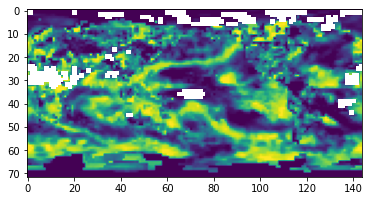

In [104]:
#plot the globe for one of the dates
plt.imshow(terc_ds.sel(T=cftime.Datetime360Day(2020, 12, 16, 0, 0, 0, 0))["prcp_percentiles"].values)

In [105]:
#clip to country
df_bound = gpd.read_file(adm1_bound_path)
ds_clip = terc_ds.rio.set_spatial_dims(x_dim=config.LONGITUDE, y_dim=config.LATITUDE).rio.write_crs("EPSG:4326").rio.clip(df_bound.geometry.apply(mapping), df_bound.crs, all_touched=True)

In [106]:
ds_clip

<xarray.Dataset>
Dimensions:           (T: 505, lat: 4, lon: 2)
Coordinates:
  * lat               (lat) float64 -8.75 -11.25 -13.75 -16.25
  * lon               (lon) float64 33.75 36.25
  * T                 (T) object 1979-01-16 00:00:00 ... 2021-01-16 00:00:00
    spatial_ref       int64 0
Data variables:
    prcp_percentiles  (T, lat, lon) float32 0.7335 nan 0.6976 ... 0.5018 0.6405
Attributes:
    grid_mapping:  spatial_ref

In [107]:
#fraction of values with percentile <= 0.33, i.e. below average value. Should be around 0.33
ds_clip_notnan=ds_clip.prcp_percentiles.values[~np.isnan(ds_clip.prcp_percentiles.values)]
np.count_nonzero(ds_clip_notnan<=0.33)/np.count_nonzero(ds_clip_notnan)

0.3340486409155937

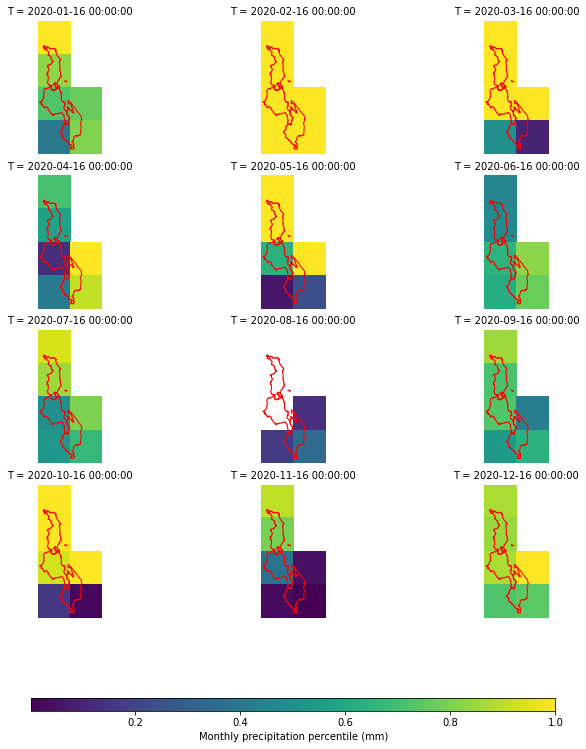

In [108]:
#show the data for each month of 2020, clipped to MWI
g=ds_clip.sel(T=ds_clip.T.dt.year.isin([2020])).prcp_percentiles.plot(
    col="T",
    col_wrap=3,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
        "label":"Monthly precipitation percentile (mm)"
    },
)

df_bound = gpd.read_file(adm1_bound_path)
for ax in g.axes.flat:
    df_bound.boundary.plot(linewidth=1, ax=ax, color="red")
    ax.axis("off")

In [109]:
def alldates_statistics(ds,raster_transform,prob_threshold,adm_path):
    #compute statistics on level in adm_path for all dates in ds
    df_list=[]
    print(f"Number of forecasts: {len(ds.T)}")
    for date in ds.T.values:
        df=gpd.read_file(adm_path)
        ds_date=ds.sel(T=date)
        df["min_cell_touched"] = pd.DataFrame(
        zonal_stats(vectors=df, raster=ds_date["prcp_percentiles"].values, affine=raster_transform, all_touched=True,nodata=-999))["min"]
        df["date"]=pd.to_datetime(date.strftime("%Y-%m-%d"))
        df_list.append(df)
    df_hist=pd.concat(df_list)
    df_hist=df_hist.sort_values(by="date")

    for m in ["min_cell_touched"]:
        df_hist[f"{m}_se{prob_threshold}"]=np.where(df_hist[m]<=prob_threshold,1,0)
  
    df_hist["date_str"]=df_hist["date"].dt.strftime("%Y-%m")

    return df_hist

In [110]:
#compute whether the minimum cell that touches an admin1 region has a percentile of 0.33 or below for each month since 2010
df_terc=alldates_statistics(terc_ds.sel(T=terc_ds.T.dt.year.isin(range(2010,2021))),terc_ds.rio.transform(),0.33,adm2_bound_path)
#remove the day from the date as it is monthly data and easier for further processing
df_terc["date_month"]=df_terc.date.dt.to_period("M")

Number of forecasts: 132


`rasterstats.zonal_stats` overlays the raster data with the shapefile that I still don't fully understand. If e.g. the range of longitude coordinates is not as `zonal_stats` it expects, it overlays the shapefile with another part of the world.   
Thus, a double check that the `min_cell_touched` values in `df_terc` are one of the actual raw values in `ds_clip` on the same date

In [111]:
ds_clip.sel(T=cftime.Datetime360Day(2020, 12, 16, 0, 0, 0, 0))["prcp_percentiles"].values

array([[0.8716265 ,        nan],
       [0.8455215 ,        nan],
       [0.8731764 , 1.        ],
       [0.72264385, 0.7444444 ]], dtype=float32)

In [112]:
df_terc[df_terc.date=="2020-12-16"]

,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry,min_cell_touched,min_cell_touched_se0.33,date_str,date_month
17,1.378986,0.058816,Mwanza,MW306,None,None,None,Southern,MW3,Malawi,MW,2020-12-16,2018-10-16,None,"POLYGON ((34.49782 -15.42673, 34.49805 -15.427...",0.722644,0,2020-12,2020-12
18,7.568139,0.869944,Mzimba,MW105,None,None,None,Northern,MW1,Malawi,MW,2020-12-16,2018-10-16,None,"MULTIPOLYGON (((34.07900 -11.38773, 34.07986 -...",0.845522,0,2020-12,2020-12
19,0.472461,0.011627,Mzuzu City,MW107,None,None,None,Northern,MW1,Malawi,MW,2020-12-16,2018-10-16,None,"POLYGON ((34.01161 -11.36523, 34.01255 -11.365...",0.845522,0,2020-12,2020-12
20,2.553469,0.136825,Neno,MW313,None,None,None,Southern,MW3,Malawi,MW,2020-12-16,2018-10-16,None,"POLYGON ((34.60303 -15.21156, 34.60392 -15.211...",0.722644,0,2020-12,2020-12
21,3.985252,0.345984,Nkhata Bay,MW103,None,None,None,Northern,MW1,Malawi,MW,2020-12-16,2018-10-16,None,"POLYGON ((34.21913 -11.05184, 34.21931 -11.052...",0.845522,0,2020-12,2020-12
22,5.021443,0.360133,Nkhotakota,MW202,None,None,None,Central,MW2,Malawi,MW,2020-12-16,2018-10-16,None,"MULTIPOLYGON (((34.12632 -12.39760, 34.12703 -...",0.845522,0,2020-12,2020-12
29,1.942617,0.140880,Thyolo,MW307,None,None,None,Southern,MW3,Malawi,MW,2020-12-16,2018-10-16,None,"POLYGON ((35.13929 -15.85653, 35.14019 -15.856...",0.722644,0,2020-12,2020-12
24,3.135728,0.273175,Ntcheu,MW209,None,None,None,Central,MW2,Malawi,MW,2020-12-16,2018-10-16,None,"POLYGON ((34.75768 -14.43573, 34.75794 -14.436...",0.722644,0,2020-12,2020-12
25,2.085826,0.143596,Ntchisi,MW203,None,None,None,Central,MW2,Malawi,MW,2020-12-16,2018-10-16,None,"POLYGON ((33.91324 -13.01322, 33.91408 -13.013...",0.873176,0,2020-12,2020-12
26,1.777164,0.119761,Phalombe,MW309,None,None,None,Southern,MW3,Malawi,MW,2020-12-16,2018-10-16,None,"POLYGON ((35.85133 -15.44877, 35.84327 -15.534...",0.744444,0,2020-12,2020-12


In [113]:
#due to the methodology, this is larger than the fraction of raster cells with below average value
print(f"fraction of adm2s with below average value:",len(df_terc[df_terc["min_cell_touched_se0.33"]==1])/len(df_terc))

fraction of adm2s with below average value: 0.4192708333333333


In [114]:
#Hmm strange that there is such a large difference across months.. Should in theory all be 0.33?
#compute fraction of values having below average per month
df_terc_month=df_terc.groupby(df_terc.date.dt.month).sum()
df_terc_month['fract_below']=df_terc_month["min_cell_touched_se0.33"]/df_terc.groupby(df_terc.date.dt.month).count()["min_cell_touched_se0.33"]#/(len(df_terc.ADM2_EN.unique())*len(df_terc.date.dt.year.unique()))
df_terc_month[["fract_below"]]

,fract_below
date,
1,0.196023
2,0.406250
3,0.548295
4,0.357955
5,0.559659
6,0.548295
7,0.460227
8,0.377841
9,0.275568


In [115]:
#Hmm would have expected more deviation per year, e.g. I thought 2011 was very little rainfall year?
#compute fraction of values having below average per month
df_terc_year=df_terc.groupby(df_terc.date.dt.year).sum()
df_terc_year['fract_below']=df_terc_year["min_cell_touched_se0.33"]/df_terc.groupby(df_terc.date.dt.year).count()["min_cell_touched_se0.33"]#/(len(df_terc.ADM2_EN.unique())*len(df_terc.date.dt.year.unique()))
df_terc_year[["fract_below"]]

,fract_below
date,
2010,0.442708
2011,0.317708
2012,0.500000
2013,0.411458
2014,0.489583
2015,0.567708
2016,0.598958
2017,0.427083
2018,0.296875


In [116]:
#compute fraction of values having below average per ADMIN2
df_terc_adm2=df_terc.groupby("ADM2_EN").sum()
df_terc_adm2["fract_below"]=df_terc_adm2["min_cell_touched_se0.33"]/df_terc.groupby("ADM2_EN").count()["min_cell_touched_se0.33"]
df_terc_adm2[["fract_below"]]

,fract_below
ADM2_EN,
Balaka,0.651515
Blantyre,0.553030
Blantyre City,0.553030
Chikwawa,0.553030
Chiradzulu,0.439394
Chitipa,0.378788
Dedza,0.363636
Dowa,0.363636
Karonga,0.378788


### Observed dryspells and correlation with below average monthly rainfall
**note: the list of dry spells used here is preliminary, thus the correlations will likely change but the processing should be the same**
Process the observed dryspell list as outputed by `malawi/scripts/mwi_chirps_dry_spell_detection.R` and correlate the occurence of a dry spell with below-average monthly and seasonal rainfall

As first analysis we are focussing on the sole occurence of a dry spell per admin2. This can be extended to e.g. duration, number of dry spells, and geographical spread

Questions
- Does it make sense to use the datae of dry spell confirmation, or more logical to use the start date?

In [117]:
df_ds=pd.read_csv(os.path.join(country_data_exploration_dir,"dryspells","mwi_dry_spells_list.csv")) #"../Data/transformed/mwi_dry_spells_list.csv")

In [118]:
df_ds["dry_spell_first_date"]=pd.to_datetime(df_ds["dry_spell_first_date"])
df_ds["dry_spell_confirmation"]=pd.to_datetime(df_ds["dry_spell_confirmation"])
df_ds["ds_conf_m"]=df_ds.dry_spell_confirmation.dt.to_period("M")

In [119]:
#for now only want to know if a dry spell occured in a given month, so drop those that have several dry spells confirmed within a month
df_ds_drymonth=df_ds.drop_duplicates(["ADM2_EN","ds_conf_m"]).groupby(["ds_conf_m","ADM2_EN"],as_index=False).agg("count")[["ds_conf_m","ADM2_EN","dry_spell_confirmation"]] #["ADM2_EN"]

In [120]:
df_ds_drymonth

,ds_conf_m,ADM2_EN,dry_spell_confirmation
0,2010-01,Blantyre,1
1,2010-01,Likoma,1
2,2010-01,Mulanje,1
3,2010-01,Mwanza,1
4,2010-01,Thyolo,1
...,...,...,...
1197,2020-11,Mangochi,1
1198,2020-11,Neno,1
1199,2020-11,Nsanje,1
1200,2020-11,Ntcheu,1


In [121]:
#merge the dry spells with the info if a month had below average rainfall
#merge on outer such that all dates present in one of the two are included
df_comb=df_ds_drymonth.merge(df_terc,how="outer",left_on=["ds_conf_m","ADM2_EN"],right_on=["date_month","ADM2_EN"])

In [122]:
#dates that are not present in the dry spell list, but are in the observed rainfall df, thus have no dry spells
df_comb.dry_spell_confirmation=df_comb.dry_spell_confirmation.replace(np.nan,0)

[[1769 1253]
 [ 684  518]]


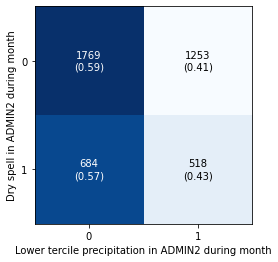

In [123]:
#contigency matrix rainfall and dry spells for all months
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_target =    df_comb["dry_spell_confirmation"]
y_predicted = df_comb["min_cell_touched_se0.33"]

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
ax.set_ylabel("Dry spell in ADMIN2 during month")
ax.set_xlabel("Lower tercile precipitation in ADMIN2 during month")
plt.show()

In [124]:
#This will eventually be defined by output from R script but for now making rough selection of months generally considered rainy season
df_comb_rainyseas=df_comb[df_comb.date_month.dt.month.isin([11,12,1,2,3,4])]

[[1119  743]
 [ 162   88]]


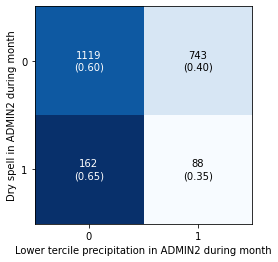

In [125]:
#contigency matrix rainfall and dry spells for rainy season months
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_target =    df_comb_rainyseas["dry_spell_confirmation"]
y_predicted = df_comb_rainyseas["min_cell_touched_se0.33"]

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
ax.set_ylabel("Dry spell in ADMIN2 during month")
ax.set_xlabel("Lower tercile precipitation in ADMIN2 during month")
plt.show()